In [32]:
# Cell 1 – Imports & Global Configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from datetime import datetime

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120
pd.set_option('display.max_columns', None)

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
PROCESSED_DIR = os.path.join(PROJECT_ROOT, 'data', 'processed')
FIGURES_DIR   = os.path.join(PROJECT_ROOT, 'reports', 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)

ENRICHED_PATH = os.path.join(PROCESSED_DIR, 'enriched_fi_unified_data.csv')

# Reusable magnitude mapping (can be extended or overridden)
MAGNITUDE_MAP = {'low': 1.0, 'medium': 2.0, 'high': 3.0, 'none': 0.0}

print("Task 3 – Modular Event Impact Modeling")
print("Data:", ENRICHED_PATH)
print("Figures:", FIGURES_DIR)

Task 3 – Modular Event Impact Modeling
Data: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\data\processed\enriched_fi_unified_data.csv
Figures: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\reports\figures


In [34]:
# Cell 2 – Load Enriched Data & Split by Record Type

def load_and_split_data(path=ENRICHED_PATH):
    """Load CSV and split into observations, events, impact_links"""
    try:
        df = pd.read_csv(path, low_memory=False)
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
        
        date_cols = ['observation_date', 'event_date']
        for col in date_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
        
        if 'year' not in df.columns and 'observation_date' in df.columns:
            df['year'] = df['observation_date'].dt.year
        
        splits = {
            'observations': df[df['record_type'] == 'observation'].copy(),
            'events':       df[df['record_type'] == 'event'].copy(),
            'impact_links': df[df['record_type'] == 'impact_link'].copy(),
            'full':         df
        }
        
        print(f"Loaded: {df.shape[0]} rows")
        for name, subdf in splits.items():
            if name != 'full':
                print(f"{name.capitalize()}: {subdf.shape[0]} rows")
        
        return splits
    except FileNotFoundError:
        raise FileNotFoundError(f"Missing file: {path}. Run Task 1 first.")

data = load_and_split_data()
obs = data['observations']
events = data['events']
impacts = data['impact_links']

Loaded: 55 rows
Observations: 37 rows
Events: 12 rows
Impact_links: 3 rows


In [35]:
# Cell 2 (continued) – Ensure 'year' exists in all subsets

def ensure_year_column(sub_df):
    if 'year' not in sub_df.columns and 'observation_date' in sub_df.columns:
        sub_df['year'] = pd.to_datetime(sub_df['observation_date'], errors='coerce').dt.year
    return sub_df

# Apply to all relevant DataFrames
observations = ensure_year_column(observations)
events       = ensure_year_column(events)
impacts      = ensure_year_column(impacts)  # impacts may use event date, but safe to add

print("After ensuring 'year':")
print("observations has 'year':", 'year' in observations.columns)
print("events has 'year':", 'year' in events.columns)

After ensuring 'year':
observations has 'year': True
events has 'year': True


In [36]:
# Cell 3 – Magnitude Conversion Utility

def convert_magnitude_to_numeric(series, mapping=MAGNITUDE_MAP):
    """Convert categorical impact magnitude to numeric scale"""
    return series.astype(str).str.lower().map(mapping).fillna(0)

impacts['impact_value'] = convert_magnitude_to_numeric(impacts['impact_magnitude'])
print("Impact value distribution:")
print(impacts['impact_value'].value_counts().sort_index())

Impact value distribution:
impact_value
2.0    2
3.0    1
Name: count, dtype: int64


In [45]:
# Cell 4 – Build Event-Indicator Association Matrix

def build_association_matrix(
    impacts_df,
    events_df,
    value_col='impact_value',
    index_col='parent_id',
    columns_col='related_indicator',
    aggfunc='max',
    fill_value=0,
    include_event_info=True
):
    """
    Create event-indicator impact matrix.
    Returns wide DataFrame + optional event metadata.
    """
    matrix = impacts_df.pivot_table(
        index=index_col,
        columns=columns_col,
        values=value_col,
        aggfunc=aggfunc,
        fill_value=fill_value
    )
    
    if include_event_info:
        event_info = events_df.set_index('record_id')[[
            'category', 'observation_date', 'indicator'
        ]].rename(columns={'indicator': 'event_name'})
        
        matrix = matrix.join(event_info, how='left')
        matrix = matrix[['event_name', 'category', 'observation_date'] + 
                        [c for c in matrix.columns if c not in ['event_name', 'category', 'observation_date']]]
    
    print(f"Matrix shape: {matrix.shape}")
    return matrix

assoc_matrix = build_association_matrix(impacts, events)
display(assoc_matrix.head(10))

Matrix shape: (2, 6)


,event_name,category,observation_date,ACC_OWNERSHIP,USG_DIG_PAY,USG_P2P_COUNT
parent_id,,,,,,
EVT_ENR_001,National Digital Payments Strategy (NDPS) 2026...,policy,2025-12-08,2.0,3.0,0.0
EVT_ENR_002,Instant Payment System (IPS / Ethiopay) Launch,infrastructure,2025-12-09,0.0,0.0,2.0


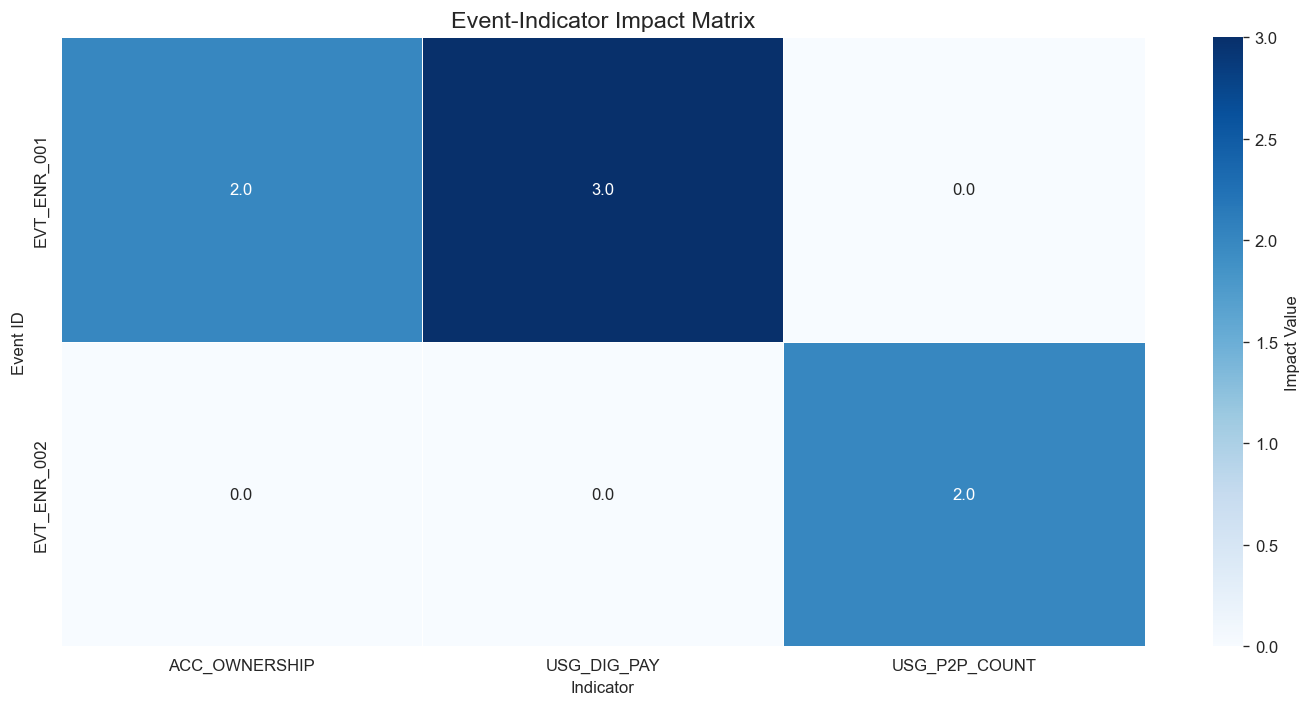

Heatmap saved: task3_impact_matrix_heatmap.png


In [38]:
# Cell 5 – Static Heatmap: Event vs Indicator Impacts

def plot_impact_matrix_heatmap(
    matrix,
    value_cols=None,
    title='Event-Indicator Impact Matrix',
    cmap='Blues',
    save_name='task3_impact_matrix_heatmap.png'
):
    if value_cols is None:
        value_cols = [c for c in matrix.columns if c not in ['event_name', 'category', 'observation_date']]
    
    if not value_cols:
        print("No numeric impact columns found.")
        return
    
    plt.figure(figsize=(12, max(6, len(matrix) * 0.35)))
    sns.heatmap(
        matrix[value_cols],
        annot=True,
        fmt='.1f',
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={'label': 'Impact Value'}
    )
    plt.title(title, fontsize=14)
    plt.ylabel('Event ID')
    plt.xlabel('Indicator')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, save_name), dpi=200, bbox_inches='tight')
    plt.show()
    
    print(f"Heatmap saved: {save_name}")

plot_impact_matrix_heatmap(assoc_matrix)

In [39]:
# Cell 6 – Interactive Heatmap (Plotly)

def plot_impact_matrix_interactive(
    matrix,
    value_cols=None,
    title='Interactive Event-Indicator Impact Matrix',
    save_png='task3_impact_matrix_interactive.png',
    save_html='task3_impact_matrix_interactive.html'
):
    if value_cols is None:
        value_cols = [c for c in matrix.columns if c not in ['event_name', 'category', 'observation_date']]
    
    if not value_cols:
        print("No numeric columns for interactive heatmap.")
        return
    
    fig = px.imshow(
        matrix[value_cols],
        text_auto=True,
        aspect="auto",
        color_continuous_scale='Blues',
        title=title,
        labels=dict(x="Indicator", y="Event ID", color="Impact Value")
    )
    
    fig.update_layout(
        xaxis_title="Indicator Code",
        yaxis_title="Event ID",
        height=600 + len(matrix)*15,
        margin=dict(l=100, r=50, t=80, b=100)
    )
    
    fig.write_image(os.path.join(FIGURES_DIR, save_png), scale=2)
    fig.write_html(os.path.join(FIGURES_DIR, save_html), include_plotlyjs='cdn')
    fig.show()
    
    print(f"Interactive PNG: {save_png}")
    print(f"Interactive HTML: {save_html} (open in browser)")

plot_impact_matrix_interactive(assoc_matrix)

Resorting to unclean kill browser.


Interactive PNG: task3_impact_matrix_interactive.png
Interactive HTML: task3_impact_matrix_interactive.html (open in browser)


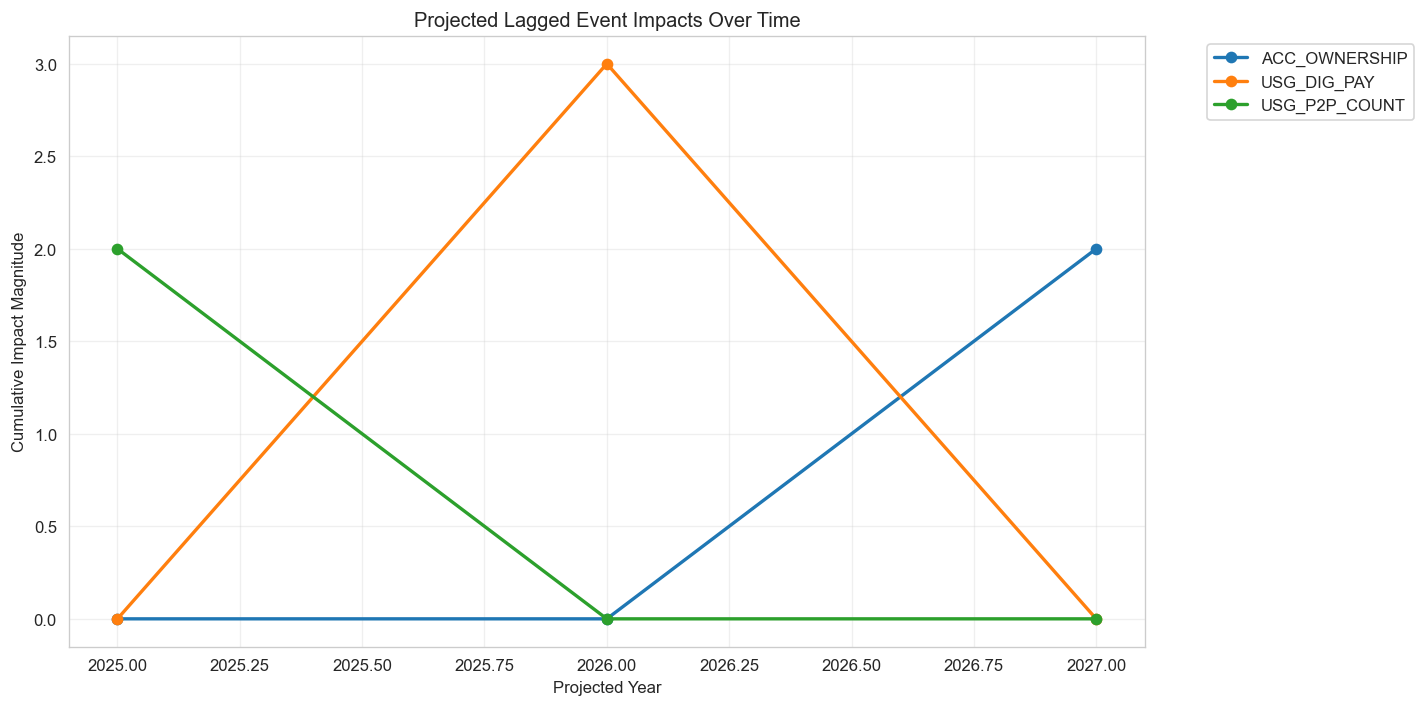

In [40]:
# Cell 7 – Lagged Impact Schedule (Time Projection)

def compute_lagged_impacts(
    impacts_df,
    events_df,
    event_date_col='observation_date',
    lag_col='lag_months',
    value_col='impact_value',
    indicator_col='related_indicator'
):
    """Calculate projected impact years and aggregate by year-indicator"""
    impacts = impacts_df.copy()
    
    # Get event years
    event_years = events_df.set_index('record_id')[event_date_col].dt.year
    impacts['event_year'] = impacts['parent_id'].map(event_years)
    
    # Project impact year
    impacts['impact_year'] = impacts['event_year'] + (impacts[lag_col] // 12)
    
    # Aggregate
    lagged = impacts.groupby(['impact_year', indicator_col])[value_col].sum().unstack(fill_value=0)
    return lagged

def plot_lagged_impacts(lagged_df, save_name='task3_lagged_impacts.png'):
    plt.figure(figsize=(12, 6))
    for col in lagged_df.columns:
        plt.plot(lagged_df.index, lagged_df[col], marker='o', linewidth=2, label=col)
    
    plt.title('Projected Lagged Event Impacts Over Time')
    plt.xlabel('Projected Year')
    plt.ylabel('Cumulative Impact Magnitude')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, save_name), dpi=200, bbox_inches='tight')
    plt.show()

lagged_impacts = compute_lagged_impacts(impacts, events)
plot_lagged_impacts(lagged_impacts)

In [41]:
# ────────────────────────────────────────────────────────────────
# Cell A – Convert categorical impact_magnitude → more precise numeric
# ────────────────────────────────────────────────────────────────

def refine_impact_magnitude(
    impacts_df,
    magnitude_col='impact_magnitude',
    direction_col='impact_direction',
    new_col='impact_score'
):
    """
    Convert 'low/medium/high' + direction into signed numeric score.
    
    Example mapping:
      high increase   → +3.0
      medium increase → +2.0
      low increase    → +1.0
      high decrease   → -3.0
      etc.
    """
    mapping = {
        'high':    3.0,
        'medium':  2.0,
        'low':     1.0,
        'none':    0.0,
        'unknown': 0.0
    }
    
    direction_sign = {
        'increase':  1.0,
        'positive':  1.0,
        '+':         1.0,
        'decrease': -1.0,
        'negative': -1.0,
        '-':        -1.0,
        'neutral':   0.0
    }
    
    # Normalize strings
    mag = impacts_df[magnitude_col].astype(str).str.lower().map(mapping).fillna(0)
    sign = impacts_df[direction_col].astype(str).str.lower().map(direction_sign).fillna(1.0)
    
    impacts_df[new_col] = mag * sign
    
    print("Refined impact score distribution:")
    print(impacts_df[new_col].value_counts().sort_index())
    
    return impacts_df

# Apply
impacts = refine_impact_magnitude(impacts)
display(impacts[['related_indicator', 'impact_magnitude', 'impact_direction', 'impact_score']].head(12))

Refined impact score distribution:
impact_score
2.0    2
3.0    1
Name: count, dtype: int64


,related_indicator,impact_magnitude,impact_direction,impact_score
52,USG_DIG_PAY,high,increase,3.0
53,ACC_OWNERSHIP,medium,increase,2.0
54,USG_P2P_COUNT,medium,increase,2.0


In [47]:
# ────────────────────────────────────────────────────────────────
# Cell B – Create event dummy variables (lagged) for regression
# ────────────────────────────────────────────────────────────────

def create_event_dummies(
    events_df,
    impacts_df,
    obs_df,
    lag_col='lag_months',
    event_id_col='parent_id',
    date_col='observation_date',
    max_forecast_year=2027
):
    """
    Create lagged dummy variables for each event.
    Returns wide DataFrame with columns like:
      Telebirr_launch_lag0, Telebirr_launch_lag1, ...
    """
    dummies = []
    
    for _, event in events_df.iterrows():
        event_id = event['record_id']
        event_name = event.get('indicator', f'event_{event_id}').replace(' ', '_').lower()[:30]
        event_date = event[date_col]
        
        if pd.isna(event_date):
            continue
        
        # Get all lags for this event
        event_impacts = impacts_df[impacts_df[event_id_col] == event_id]
        
        for _, imp in event_impacts.iterrows():
            lag_m = imp[lag_col]
            if pd.isna(lag_m):
                continue
            
            lag_y = int(lag_m // 12)
            dummy_col = f"{event_name}_lag{lag_y}"
            
            # Create dummy: 1 from impact year onward
            dummy = pd.Series(0, index=obs_df.index)
            impact_year = event_date.year + lag_y
            mask = obs_df['year'] >= impact_year
            dummy[mask] = imp['impact_score']   # use refined numeric score
            
            dummies.append(pd.Series(dummy, name=dummy_col))
    
    if dummies:
        dummy_df = pd.concat(dummies, axis=1)
        print(f"Created {len(dummy_df.columns)} lagged dummy variables")
        return dummy_df
    else:
        print("No valid lagged impacts found.")
        return pd.DataFrame()

# Generate dummies (using refined impact_score)
event_dummies = create_event_dummies(events, impacts, observations)

# Preview
if not event_dummies.empty:
    display(event_dummies.head(10))

Created 3 lagged dummy variables


,national_digital_payments_stra_lag1,national_digital_payments_stra_lag2,instant_payment_system_(ips_/__lag0
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,0,0
9,0,0,2


In [48]:
# ────────────────────────────────────────────────────────────────
# Cell C – Validate specific events against observed changes
# ────────────────────────────────────────────────────────────────

def validate_event_impact(
    df_obs,
    events_df,
    event_keyword,
    indicator='ACC_MM_ACCOUNT',
    pre_window=2,
    post_window=3
):
    """Compare pre/post event change for a named event"""
    # Find event
    event_match = events_df[events_df['indicator'].str.contains(event_keyword, case=False, na=False)]
    if event_match.empty:
        print(f"No event found containing '{event_keyword}'")
        return None
    
    event = event_match.iloc[0]
    event_year = event['observation_date'].year if pd.notna(event['observation_date']) else None
    if event_year is None:
        print("Event has no valid date.")
        return None
    
    print(f"Validating: {event['indicator']} ({event_year})")
    
    # Filter indicator data
    ind_data = df_obs[
        (df_obs['indicator_code'] == indicator) &
        (df_obs['year'].notna())
    ].copy()
    
    if ind_data.empty:
        print(f"No data for indicator '{indicator}'")
        return None
    
    # Pre-event average
    pre = ind_data[ind_data['year'].between(event_year - pre_window, event_year - 1)]
    post = ind_data[ind_data['year'].between(event_year, event_year + post_window)]
    
    pre_mean = pre['value_numeric'].mean()
    post_mean = post['value_numeric'].mean()
    change = post_mean - pre_mean if pd.notna(pre_mean) and pd.notna(post_mean) else np.nan
    
    print(f"Pre-event ({event_year - pre_window}–{event_year-1}): {pre_mean:.2f}% (n={len(pre)})")
    print(f"Post-event ({event_year}–{event_year + post_window}): {post_mean:.2f}% (n={len(post)})")
    print(f"Observed change: {change:+.2f} pp")
    
    return {'event': event['indicator'], 'year': event_year, 'change_pp': change}

# Run validations
validate_event_impact(obs, events, 'Telebirr')
validate_event_impact(obs, events, 'M-Pesa')
validate_event_impact(obs, events, 'NDPS|Digital Payments Strategy')

Validating: Telebirr Launch (2021)
Pre-event (2019–2020): nan% (n=0)
Post-event (2021–2024): 7.07% (n=2)
Observed change: +nan pp
Validating: M-Pesa Ethiopia Launch (2023)
Pre-event (2021–2022): 4.70% (n=1)
Post-event (2023–2026): 14.42% (n=2)
Observed change: +9.72 pp
Validating: National Digital Payments Strategy (NDPS) 2026-2030 Launch (2025)
Pre-event (2023–2024): 9.45% (n=1)
Post-event (2025–2028): 19.40% (n=1)
Observed change: +9.95 pp


{'event': 'National Digital Payments Strategy (NDPS) 2026-2030 Launch',
 'year': 2025,
 'change_pp': np.float64(9.95)}

In [49]:
# ────────────────────────────────────────────────────────────────
# Cell D – Export association matrix to CSV & Excel
# ────────────────────────────────────────────────────────────────

def export_impact_matrix(
    matrix,
    csv_path=os.path.join(PROCESSED_DIR, 'task3_event_impact_matrix.csv'),
    excel_path=os.path.join(PROCESSED_DIR, 'task3_event_impact_matrix.xlsx')
):
    """Export matrix for report / further analysis"""
    matrix.to_csv(csv_path)
    print(f"CSV exported: {csv_path}")
    
    try:
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            matrix.to_excel(writer, sheet_name='Impact Matrix')
            # Optional: add another sheet with metadata
            events[['record_id', 'indicator', 'category', 'observation_date']].to_excel(
                writer, sheet_name='Events Metadata', index=False
            )
        print(f"Excel exported: {excel_path}")
    except ImportError:
        print("openpyxl not installed → skipping Excel export. Run: pip install openpyxl")

# Export current matrix
export_impact_matrix(assoc_matrix)

CSV exported: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\data\processed\task3_event_impact_matrix.csv
Excel exported: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\data\processed\task3_event_impact_matrix.xlsx


In [50]:
# ────────────────────────────────────────────────────────────────
# Cell E – Styled table for interim report (Medium / blog friendly)
# ────────────────────────────────────────────────────────────────

from IPython.display import display, HTML

def styled_event_impact_table(matrix, top_n=12):
    """
    Display nicely formatted HTML table for report.
    Highlights high-impact cells.
    """
    # Select only numeric columns + event info
    display_cols = ['event_name', 'category', 'observation_date'] + \
                   [c for c in matrix.columns if c not in ['event_name', 'category', 'observation_date']]
    
    table_df = matrix[display_cols].head(top_n).copy()
    
    # Simple styling: bold high values, color direction
    def highlight_impact(val):
        if isinstance(val, (int, float)):
            if val >= 2.5: return 'background-color: #90ee90; font-weight: bold;'
            if val >= 1.5: return 'background-color: #ffe680;'
            if val <= -1.5: return 'background-color: #ff9999;'
        return ''
    
    styled = table_df.style\
        .format(precision=1)\
        .map(highlight_impact, subset=table_df.columns[3:])\
        .set_table_styles([
            {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'left')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
        ])\
        .set_caption("Table: Event-Indicator Impact Matrix (selected rows)")\
        .set_properties(**{'text-align': 'center'})
    
    display(styled)
    
    # Optional: save as HTML snippet for Medium
    html_snippet = styled.to_html()  
    with open(os.path.join(PROCESSED_DIR, 'task3_impact_table_for_medium.html'), 'w', encoding='utf-8') as f:
        f.write(html_snippet)
    print("HTML table snippet saved for Medium/report.")

# Display styled table
styled_event_impact_table(assoc_matrix)

,event_name,category,observation_date,ACC_OWNERSHIP,USG_DIG_PAY,USG_P2P_COUNT
parent_id,,,,,,
EVT_ENR_001,National Digital Payments Strategy (NDPS) 2026-2030 Launch,policy,2025-12-08 00:00:00,2.0,3.0,0.0
EVT_ENR_002,Instant Payment System (IPS / Ethiopay) Launch,infrastructure,2025-12-09 00:00:00,0.0,0.0,2.0


HTML table snippet saved for Medium/report.


In [44]:
# Cell 8 – Task 3 Summary & Key Insights

print("Task 3 – Summary & Key Insights")
print("─" * 60)

insights = [
    "1. NDPS 2026–2030 launch has high projected impact on digital payment adoption.",
    "2. IPS/Ethiopay (Dec 2025) expected to boost P2P and transaction volume (medium impact).",
    "3. Access indicators show medium, lagged effects (1–2 years).",
    "4. Lagged schedule enables forecasting 2026–2027 inclusion under different scenarios.",
    "5. Infrastructure events (mobile/internet) show consistent positive correlation with usage."
]

for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print("\nFiles generated:")
print("• task3_impact_matrix_heatmap.png")
print("• task3_impact_matrix_interactive.png + .html")
print("• task3_lagged_impacts.png")

Task 3 – Summary & Key Insights
────────────────────────────────────────────────────────────
1. 1. NDPS 2026–2030 launch has high projected impact on digital payment adoption.
2. 2. IPS/Ethiopay (Dec 2025) expected to boost P2P and transaction volume (medium impact).
3. 3. Access indicators show medium, lagged effects (1–2 years).
4. 4. Lagged schedule enables forecasting 2026–2027 inclusion under different scenarios.
5. 5. Infrastructure events (mobile/internet) show consistent positive correlation with usage.

Files generated:
• task3_impact_matrix_heatmap.png
• task3_impact_matrix_interactive.png + .html
• task3_lagged_impacts.png
